In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline 
import seaborn as sns
from scipy import stats, integrate

In [2]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics

In [3]:
from mlxtend.plotting import plot_learning_curves
from mlxtend.plotting import plot_decision_regions

In [4]:
# Data from MAGIC Gamma Ray Telescope 
#   (Major Atmospheric Gamma Imaging Cherenkov Telescopes)
#
# Data hosted by UC Irvine Machine Learning Repository (https://archive.ics.uci.edu/ml/index.php):
#  https://archive.ics.uci.fAsymedu/ml/datasets/MAGIC+Gamma+Telescope
#
# Infromation on data and variables:
#  https://archive.ics.uci.edu/ml/machine-learning-databases/magic/magic04.names
#  
# Paper with some details on the data
#  http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.135.6914&rep=rep1&type=pdf
#
# Paper describing variable definitions in more detail:
#  http://iopscience.iop.org/article/10.1088/0954-3899/23/9/004/pdf
#
# Important variables:
#    1.  fLength:  continuous  # major axis of ellipse [mm]
#    2.  fWidth:   continuous  # minor axis of ellipse [mm] 
#    3.  fSize:    continuous  # 10-log of sum of content of all pixels [in #phot]
#    4.  fConc:    continuous  # ratio of sum of two highest pixels over fSize  [ratio]
#    5.  fConc1:   continuous  # ratio of highest pixel over fSize  [ratio]
#    6.  fAsym:    continuous  # distance from highest pixel to center, projected onto major axis [mm]
#    7.  fM3Long:  continuous  # 3rd root of third moment along major axis  [mm] 
#    8.  fM3Trans: continuous  # 3rd root of third moment along minor axis  [mm]
#    9.  fAlpha:   continuous  # angle of major axis with vector to origin [deg]
#   10.  fDist:    continuous  # distance from origin to center of ellipse [mm]
#   11.  class:    g,h         # gamma (signal), hadron (background)

# Class Distribution:
#
#   g = gamma (signal):     12332
#   h = hadron (background): 6688


data_path = 'https://archive.ics.uci.edu/ml/machine-learning-databases/magic/magic04.data'
variable_names =['fLength',   'fWidth',  'fSize', 'fConc','fConc1', 'fAsym', 
                 'fM3Long', 'fM3Trans', 'fAlpha', 'fDist', 'class']

df = pd.read_csv(data_path, names=variable_names, na_values='?')

# Add a gamma boolean column
df.loc[df['class'] == 'g', 'isGamma'] = True
df.loc[df['class'] == 'h', 'isGamma'] = False

# Add a hadron boolean column
df.loc[df['class'] == 'h', 'isHadron'] = True
df.loc[df['class'] == 'g', 'isHadron'] = False

# Create a new data frame with just gammas
df_gammas  = df[df['isGamma'] == True]

# Create a new data frame with just hadrons
df_hadrons = df[df['isHadron'] == True]

# Divide up the data inot training and testing datasets
df_gammas_train  = df_gammas.iloc[0:2000]
df_gammas_test   = df_gammas.iloc[2000:]
df_hadrons_train = df_hadrons.iloc[0:2000]
df_hadrons_test  = df_hadrons.iloc[2000:]

# Define also a small test sample for plotting purposes 
df_gammas_test_small   = df_gammas.iloc[2000:2400]
df_hadrons_test_small  = df_hadrons.iloc[2000:2400]

# put the training datasets back together
df_all_train      = pd.concat([df_gammas_train,df_hadrons_train],axis=0)
df_all_test       = pd.concat([df_gammas_test,df_hadrons_test],axis=0)
df_all_test_small = pd.concat([df_gammas_test_small,df_hadrons_test_small],axis=0)

# Define the "isGamma" column to be the column which is used to define signal events and background events
df_all_train["isGamma"]      = df_all_train["isGamma"].astype('category')
df_all_test["isGamma"]       = df_all_test["isGamma"].astype('category')
df_all_test_small["isGamma"] = df_all_test_small["isGamma"].astype('category')

### Create a 2 variable Boosted Decision Tree with Scikit-Learn

In [5]:
# Create a pandas series for each of the two variables
s_train_fAlpha    = df_all_train['fAlpha']
s_train_fM3Trans  = df_all_train['fM3Trans']

# Create a pandas dataframe containing just these two variables
df_train_fAlpha_fM3Trans = pd.DataFrame(dict(x=s_train_fAlpha, y=s_train_fM3Trans))

# Create a 2D numpy array from this dataframe
X_train = df_train_fAlpha_fM3Trans.values

# Create a 1D numpy array containing the "truth" information for each event in this training dataset
y_train = df_all_train["isGamma"].cat.codes.values

In [6]:
# Do it again, this time for your testing datasets

# Create a pandas series for each of the two variables
s_test_fAlpha          = df_all_test['fAlpha']
s_test_fM3Trans        = df_all_test['fM3Trans']
s_test_small_fAlpha    = df_all_test_small['fAlpha']
s_test_small_fM3Trans  = df_all_test_small['fM3Trans']

# Create a pandas dataframe containing just these two variables
df_test_fAlpha_fM3Trans = pd.DataFrame(dict(x=s_test_fAlpha, y=s_test_fM3Trans))
df_test_small_fAlpha_fM3Trans = pd.DataFrame(dict(x=s_test_small_fAlpha, y=s_test_small_fM3Trans))

# Create a 2D numpy array from this dataframe
X_test = df_test_fAlpha_fM3Trans.values
X_test_small = df_test_small_fAlpha_fM3Trans.values

# Create a 1D numpy array containing the "truth" information for this testing dataset
y_test = df_all_test["isGamma"].cat.codes.values
y_test_small = df_all_test_small["isGamma"].cat.codes.values


In [7]:
df_test_fAlpha_fM3Trans.head()

,x,y
2000,9.8372,7.5307
2001,22.9125,-5.3686
2002,14.8817,13.4788
2003,14.4978,37.8267
2004,18.7204,21.9683


In [8]:
X_test

array([[  9.8372,   7.5307],
       [ 22.9125,  -5.3686],
       [ 14.8817,  13.4788],
       ...,
       [ 30.2987,  -9.4662],
       [ 84.6874, -63.8389],
       [ 52.731 ,  31.4755]])

In [9]:
y_test

array([1, 1, 1, ..., 0, 0, 0], dtype=int8)

In [10]:
# create a BDT classifier using AdaBoost

bdt_d4_n2 = AdaBoostClassifier(DecisionTreeClassifier(max_depth=4),
                         algorithm="SAMME",
                         n_estimators=2)

# Train the BDT
bdt_d4_n2.fit(X_train, y_train)

# Get the BDT predicions
bdt_d4_n2_pred = bdt_d4_n2.predict(X_test)

# Get the BDT prediction probabilities
bdt_d4_n2_proba = bdt_d4_n2.predict_proba(X_test)[:,1]

In [11]:
bdt_d4_n2_pred

array([1, 1, 1, ..., 1, 0, 0], dtype=int8)

In [12]:
bdt_d4_n2_proba

array([0.73105858, 0.56712381, 0.56712381, ..., 0.56712381, 0.26894142,
       0.26894142])

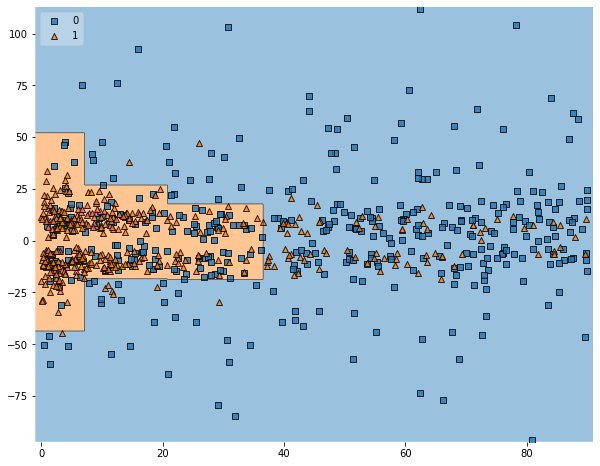

In [13]:
# If you were able to install the mlxtend.plotting  tools

fig = plt.figure(figsize=(10, 8))
fig = plot_decision_regions(X=X_test_small, y=y_test_small, clf=bdt_d4_n2, legend=2)

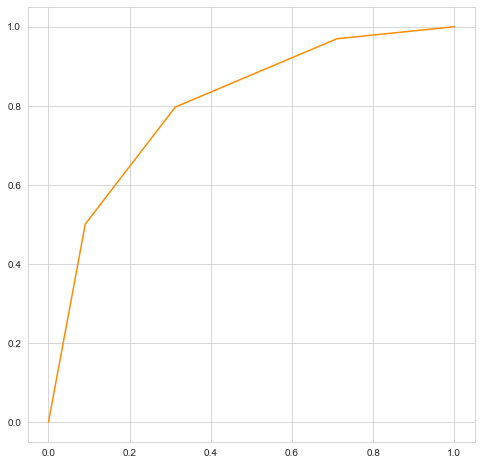

In [14]:
# Plot a ROC curve using built-in tools

sns.set_style("whitegrid")
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
fpr, tpr, thresholds = metrics.roc_curve(y_test.astype(bool), bdt_d4_n2_proba)
plt.plot(fpr, tpr, color='darkorange')


In [15]:
print(tpr)

[0.         0.50067751 0.79665118 0.96941541 1.        ]
